In [2]:
## !/usr/bin/env python
# coding: utf-8

# In[ ]:



""" 


Run Equilibrium Propagation / Backpropagation on Nanowire Networks for classification. 

Author: Alon Loeffler

Required Files/Folders: learning_functions.py | edamame | asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00.mat

"""

#IMPORTS:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

#Choose which nw:
nwChoice=700 #350 or 700

if nwChoice == 350:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
elif nwChoice == 700:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00'

#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs


In [3]:

" Create Inputs "
def createSimpleInputs(patternSize=3,numSamples=10,noise=False):
    #SIMPLE ROW INPUTS:
    np.random.seed(42)
    
    if patternSize==2:
    #2x2 pattern:
        orig_inputs=np.array((np.array([1,0,1,0]),np.array([0,1,0,1])))
    elif patternSize==3:
        #3x3 pattern:
        #plus and cross:
        orig_inputs=np.array((np.array([1,0,1,0,1,0,1,0,1]),np.array([0,1,0,1,1,1,0,1,0])))
        #simpler patterns:
#         orig_inputs=np.array((np.array([1,0,1,0,0,1,0,0,0]),np.array([0,0,0,1,0,0,1,0,1])))
    orig_inputs=orig_inputs.astype('double')
    samples=[[] for i in range(len(orig_inputs))]
    new_inputs=np.array([orig_inputs]*numSamples)

    #Pattern without Noise
    NoNoiseInputs=[]
    for targetClass in range(len(orig_inputs)):
        NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])
#     set_trace()
    #Make Noisy variants of simple patterns:
    for i in range(len(orig_inputs)):
        for j in range(numSamples):
            randVals=np.random.randint(1,patternSize) #choose how many of the 3 sources will have noise
            noiseVals=np.random.randint(patternSize, size=randVals)
            temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
            if noise:
                for val in noiseVals:
                    temp[val]=np.double(np.random.random(1))
            new_inputs[j][i][new_inputs[j][i]==1]=temp
    #         samples[i].append(temp)
    
    #RESHAPE INPUTS INTO numSamplesx2
    row1=[]
    row2=[]
    for i in range(len(new_inputs)):
        row1.append(new_inputs[i][0])
        row2.append(new_inputs[i][1])

    inputs=np.array([row1,row2])
    inputs=inputs.reshape(numSamples*2,orig_inputs.shape[1])
    targets=np.zeros(numSamples*2)
    targets[-numSamples:]=1

    #change 0 volts to 0.05
#     minVoltage=0.005
#     inputs=inputs+minVoltage
    
    return inputs, targets,orig_inputs

" Load Networks "
def buildNetworks(fileName,ManualSources=True,numDrains=2,numSources=9):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    nwJunctions=nw['number_of_junctions'][0][0]
    print('Network '+str(nwSize)+ ' Loaded')
#     this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
    numDrains=3
    ex=np.zeros(numDrains)*5#*15
    if nwSize > 500:
        eyVal=76
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates


    #IN A LINE:
    if nwSize > 500:
        exVal=75
        eyVal = 74
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates


    #Manual Source Placement:
    if ManualSources:
        if numSources==9:
            if nwSize > 500:
                elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
            else:
                elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

        elif numSources == 4:
            elecSource=[320,42,161,141]

    elecDrain=elecDrain[[0,-1]]
    
    return connectivity,elecSource,elecDrain,nwSize,nwJunctions


In [5]:


#ADD BACKPROP

#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,train,state,drains,sources,tmpTiming,tmpTargets,limVal,limVal0,limVal1,run_time=2,dt=0.01,disable_tqdm=False):
    if train:
        #remove non-target drain from simulation
        target = tmpTargets[0]
        if target == 0:
            drains = drains[0]
            print('\nDrain 1 Only')
        elif target == 1:
            drains = drains[1]
            print('\nDrain 2 Only')
    else:
        print('\nBoth Drains')
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                                   stimulus = training_stimulus,
                                   junctionMode = 'tunneling',
                                   dt = dt, T = run_time, 
                                   contactMode = 'preSet',
                                   electrodes = eles,
                                   findFirst = False,
                                   start_state = state,
                                   disable_tqdm=disable_tqdm,
                                   collapse=False,tmpTiming=tmpTiming,tmpTargets=tmpTargets,
                                   limVal=limVal,limVal0=limVal0,limVal1=limVal1)  
    JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,JS1   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[],
                    limVal=0.5,limVal0=0.5,limVal1=0.5):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets,limVal,limVal0,limVal1,lite_mode, disable_tqdm, save_steps, **kwdict)
    
#     finalIter=np.max(np.nonzero(this_realization.electrodeCurrent))
#     if finalIter < 199:
#         this_realization.electrodeCurrent=this_realization.electrodeCurrent[:finalIter+1,:]
#         this_realization.junctionVoltage=this_realization.junctionVoltage[:finalIter+1,:]
#         this_realization.junctionConductance=this_realization.junctionConductance[:finalIter+1,:]
#         this_realization.wireVoltage=this_realization.wireVoltage[:finalIter+1,:]
#         this_realization.filamentState=this_realization.filamentState[:finalIter+1,:]
#         this_realization.junctionSwitch=this_realization.junctionSwitch[:finalIter+1,:]
        #final Iter = time , use that to find / save network state
        
        
#         this_realization.TimeVector=this_realization.TimeVector[:finalIter+1,:]

    #     remove zeros from simulations that ended early:
#     this_realization.junctionCurrent
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, limVoltage,limVal0,limVal1,lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    cost      = []

#     onAmp     = simulationOptions.stimulus[3].onAmp
    
#     maxV      = onAmp *limVoltage
    
    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])
        
    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    #Simulation Run:
#     new_time=0
    stopTrain=False
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
#         print(stopTrain)
        if not stopTrain:
            this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
#         else:
#             break
        if tmpTiming[this_time]=='Train':
#             print('--------')
#             print('Training')
#             print('--------\n')
            trainTime=True
        elif tmpTiming[this_time]=='Test':
#             print('--------')
#             print('Testing')
#             print('--------\n') 
            trainTime=False

        if trainTime and this_time > 0 and not stopTrain: #if we are training, change drain voltages, otherwise just use this_stimulus
#             set_trace()
            this_stimulus[:num_drain_training]=new_stimulus

#             print('in training '+str(this_time))
#         elif this_time > trainTime:

        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]

        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff

        ## BackProp Implementation
        

        if trainTime:
#             set_trace()
            n = num_drain_training #num of drains
            y = Network.electrodeCurrent[this_time,:num_drain_training]
        else:
            n = num_drain_testing
            y = Network.electrodeCurrent[this_time,:num_drain_testing]
            
        beta      = 0.05
        grad      = np.zeros((n)) #set gradients to zero for each epoch  

        
        drainCurrents=y
        if tmpTargets[this_time] != -1: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent[tarIdx]) # normalize  | | | how do we change max current to be not arbitrary? 
        # current method - run simulation before with just that drain and use current as maxCurrent

            # change to threshold 
            d = 1 #allTargets[tarIdx]
            if trainTime:
                dsig = this_stimulus[:num_drain_training]
            else:
                dsig = this_stimulus[:num_drain_testing]

            #fixed max voltage
            # compare y with threshold - if y is >= thresh, stop the training
#             set_trace()

            #vectorised implementation

            cost.append(calc_cost(y,d))

            if trainTime and not stopTrain: #if we are training, update beta
                #Gradient without considering other electrodes:
                if tarIdx==0:
                    if drainCurrents[0]>=limVal0: #if greater or less than the target current, stop the simulation
                        this_stimulus=np.zeros(len(this_stimulus))
                        stopTrain=True
                    else:
                        stopTrain=False
                        #instead of ending session, make everything 0V (inputs + drains)
                        #make sure this doesn't last longer than filament decay length
                elif tarIdx==1:
#                     set_trace()
                    if drainCurrents[0]>=limVal1: #if greater or less than the target current, stop simulation
                        this_stimulus=np.zeros(len(this_stimulus))
                        stopTrain=True
                    else:
                        stopTrain=False
                
                if not stopTrain:        
                    grad=beta*(y-d) #y = current, d = target #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]

                    #dsig = old voltage drains, dsig2 = new voltage drains, onAmp = input voltage

                    dsig2=np.array(dsig.T+grad)
    #                     dsig2[0]=np.clip(dsig2[0],0,limVal0)
    #                     dsig2[1]=np.clip(dsig2[1],0,limVal1)

                    dsig2=np.clip(dsig2,-onAmp*0.9,onAmp*0.9) #set max and min voltages to less than inputs
#                     set_trace()
                    new_stimulus=dsig2

            elif not trainTime:
                new_stimulus=this_stimulus[:num_drain_testing]

    print('Target:' + str(tarIdx))
#     print('Voltage: '+ str(new_stimulus))
    
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
    
#     print(Network.electrodeCurrent[:,1])
    return Network,cost



def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],limVal=0.5,accThresh=0.5,increaseVal=0.5,decreaseVal=0.25,seed=42,accThreshold=False):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """  
    
    t           = [[None]*(40*(nbacks[0]+1)+1) for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    count=0
    for nback in nbacks: #how many samples to "remember" in the past before testing
        np.random.seed(seed)
        
        numTestingSamples= 40 #how many testing samples
        
        #trainingInputs (actual input)
        #traininglables (0 or 1)
        c1samples=list(np.where(traininglabels==0)[0]) #all class 1 inputs
        c2samples=list(np.where(traininglabels==1)[0]) #all class 2 inputs
        c2samplesCopy=c2samples.copy()
        #hardest memory order:
        orderTraining=[]
        for test in range(numTestingSamples):
            trainingSample1=np.random.randint(2)
            if trainingSample1==0:
                trainingSample1=np.random.choice(c1samples,1,replace=False)
                c1samples.pop(np.where(c1samples==trainingSample1[0])[0][0])
                trainingSampleRest=np.random.choice(c2samples,nback-1,replace=False)
                for j in trainingSampleRest:
                    c2samples.pop(np.where(c2samples==j)[0][0])
            elif trainingSample1==1:
                trainingSample1=np.random.choice(c2samples,1,replace=False)
                c2samples.pop(np.where(c2samples==trainingSample1[0])[0][0])
                trainingSampleRest=np.random.choice(c1samples,nback-1,replace=False)
                for j in trainingSampleRest:
                    c1samples.pop(np.where(c1samples==j)[0][0])    
            orderTraining.append(np.hstack((np.array(trainingSample1),np.array(trainingSampleRest))))
        orderTraining=np.hstack(orderTraining)

        orderTrainingLabels=traininglabels[orderTraining]
#         set_trace()
        orderTrainingLabelsNBACK=orderTrainingLabels[::nback] #these are the testing labels - every i+nback training sample is what we're testing
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(np.random.choice(np.where(testinglabels==label)[0],replace=False))
        orderTestingLabels=testinglabels[orderTesting]    
        orderTestingNBACK=np.array(orderTesting)+np.max(c2samplesCopy) #number of test per nback#       
        i = nback
#         set_trace()
        temp=[]
        j=0
        order=[None]*(len(orderTraining))
        order[:len(orderTraining)]=orderTraining
        while j<numTestingSamples: #for each testing sample 
            if i < len(order)+1: #only if we are within the total number of training samples
                order.insert(i, orderTesting[j]+np.max(c2samplesCopy)) #insert testing sample at ith position
            temp.append(i) #keep track number of inserts we made, make sure it == numTestingSamples
            i += nback+1
            j +=1
        #remove excess training (i.e. with no testing sample)
        sampleTimes=numDT*(nback+1)
        newTrainingOrder=orderTraining[:sampleTimes-numTestingSamples]
        orderTrainingLabels=orderTrainingLabels[:sampleTimes-numTestingSamples]
        order=order[:sampleTimes]
        
#         print(order)
#         print(len(order))
        #RUN SIM
        N                   = orig_inputs.shape[1]
        numClasses          = 2
        signalType          ='DC'
#         num_drain_training  = 2
        num_source_training = N
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        thresholdValues     = [None]*len(order)
        cost                = [None]*len(order)
        simVoltages         = [None]*len(order)
        accuracy    = []
        numTrainingSamples  = len(trainingInputs)
        numTestingSamples   = len(testingInputs)
        
        timing=[]
        allLabels=[]
        limVals0 = limVal
        limVals1 = limVal
        
        i=0
        numTests = 0
        nwState = None
        for val in tqdm(order): #this method loops through samples in the randomised training order
            
            #FOR EACH SAMPLE:
            
            #are we training or testing?
            if val in orderTestingNBACK:
                test=True
                train=False
            elif val in orderTraining:
                test=False
                train=True
                
            #define samples
            if train: #if we're training
                this_sample = trainingInputs[val].copy() #xs
                this_label  = traininglabels[val] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp #tune voltage based on onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = testingInputs[val-np.max(c2samplesCopy)].copy() #xs
                this_label  = testinglabels[val-np.max(c2samplesCopy)] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest #CHANGE THIS TO RAMP:
                timing.append('Test')

#             targetClassVals=[0,1] 

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-1
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 
            rampV=np.linspace(0,onAmpTest,numDT)
            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
#                 if test:
#                     tmp = rampV#*tmp[tmp>0.005]
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
            allLabels.append(this_label)
            
            stimulus=[]
            if train:
                stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][0]),dt=dt))

            elif test:
                for m in range(num_drain_testing): #create stimulus for each drain electrode
#                     set_tra
                    stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][m]),dt=dt))

            for m in range(len(tmpSources[i])): #create stimulus for each source electrode
                stimulus.append(stimulus__(biasType='Custom',T=dt*len(tmpSources[i][m]),dt=dt,customSignal=tmpSources[i][m]))
            
            signalLen=Tlen#len(stimulus[0].signal) 
            
            sim[i],nwState = getNWState_backprop(stimulus,train,nwState,drain_pool,sources,timing[i],tmpTargets[i].astype('int'),limVal,limVals0,limVals1,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)

            simVoltages[i]=(sim[i].wireVoltage)
#             set_trace()
        
            if test: #if we are testing
                #ADRIAN ACCURACY METHOD
#                 set_trace()
                t[count][i]=(calcOutputs(sim[i],sources,drain_pool))
                meanCurr0=(np.mean(t[count][i][0]))
                meanCurr1=(np.mean(t[count][i][1]))
#                 set_trace()
                if tmpTargets[i][0] == 0:
                    if meanCurr0>meanCurr1:
                        accuracy.append(1)
                    else:
                        accuracy.append(0)
                else:
                    if meanCurr1>meanCurr0:
                        accuracy.append(1)
                    else:
                        accuracy.append(0)
                if reinforcement == 'w':
                    if i >0:
                        if accuracy[numTests]==0: #if the training didn't work
                            if this_label==0: #drain 1
                                limVals0=limVals0+increaseVal #update 'max current limit based on reinforcement'
                                limVals1=limVals1-decreaseVal
                            elif this_label==1: #drain 2
                                limVals0=limVals0-decreaseVal
                                limVals1=limVals1+increaseVal   
                      
                mval1=np.max(np.nonzero(t[count][i][0]))
                mval2=np.max(np.nonzero(t[count][i][1]))
                print('Final Target Drain Current: ' + str([t[count][i][0][mval1],t[count][i][1][mval2]]))
                print('Target: ' + str(tmpTargets[i][0]))
                print('Accuracy: '+ str(accuracy[numTests]))
                numTests+=1
            else:
#                 set_trace()
                t[count][i]=(calcOutputs(sim[i],sources,[drain_pool[int(tmpTargets[i][0])]]))
                mval1=np.max(np.nonzero(t[count][i][0]))
                print('Final Target Drain Current: ' + str([t[count][i][0][mval1]]))
#             mval2=np.max(np.nonzero(t[count][i][1]))
            
#             print('All Currents: ' + str([t[count][i][0],t[count][i][1]]))

            print("LimVal1:" + str(limVals1)) #just a checking/debugging print
            print("LimVal0:" + str(limVals0)) #just a checking/debugging print

            thresholdValues[i]=[limVals0,limVals1]
            i+=1 
        
        count+=1
    return t,thresholdValues,sim,stimulus,accuracy,tmpTargets,newTrainingOrder,orderTesting,order,orderTestingLabels,testTimes,trainTimes,numTestingSamples,allLabels,orderTrainingLabels

def trainTestSplit(inputs,targets,targetClassVals=[0,1],numTestingPerClass=3,orig_inputs=[]):
    trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-numTestingPerClass],inputs[targets==targetClassVals[1]][:-numTestingPerClass]]).reshape(-1,orig_inputs.shape[1])
    testingInputs   = np.array([inputs[targets==targetClassVals[0]][-numTestingPerClass:],inputs[targets==targetClassVals[1]][-numTestingPerClass:]]).reshape(-1,orig_inputs.shape[1])
    #Define Training and Testing labels
    traininglabels=np.zeros(len(trainingInputs))
    traininglabels[:int(len(trainingInputs)/2)]=0
    traininglabels[int(len(trainingInputs)/2):int(len(trainingInputs)/2)*2]=1
    # traininglabels[int(len(trainingInputs)/3)*2:]=2
    traininglabels=traininglabels.astype(int)

    testinglabels=np.zeros(len(testingInputs))
    testinglabels[:int(len(testingInputs)/2)]=0
    testinglabels[int(len(testingInputs)/2):int(len(testingInputs)/2)*2]=1
    # testinglabels[int(len(testingInputs)/3)*2:]=2
    testinglabels=testinglabels.astype(int)
    
    return trainingInputs,testingInputs,traininglabels,testinglabels


#TASK SETUP

#Automatically chosen electrodes vs manual picked
ManualSources=True
#Number of training samples
nbacks         = [2]
numSamples=(nbacks[0]*100)+1

#Pattern (2x2 or 3x3)
patternSize= 3 #2 or 3
#Number of source electrodes (4 for 2x2, 9 for 3x3)
numSources=9 # 4 or 9

num_drain_training=1
num_drain_testing=2
allTargets=[[1,0],[0,1]]
targetClassVals=[0,1]
numTestingPerClass=20

#Amplitude:
onAmp = 0.3 #Voltage for Training
onAmpTest = 0.1 #Voltage for Testing

#Noise
noisey=False

#create networks
connectivity,sources,drain_pool,nwSize,nwJunctions=buildNetworks(fileName,ManualSources,num_drain_training,numSources)

#create samples
inputs,targets,orig_inputs=createSimpleInputs(patternSize,numSamples,noisey) #pattern size (e.g 3x3 = 3), number of samples, noise

#split samples to train test
trainingInputs,testingInputs,traininglabels,testinglabels = trainTestSplit(inputs,targets,targetClassVals,numTestingPerClass,orig_inputs=orig_inputs)
#Run n-back Task

#Time Parameters
dt=0.01
Tlen = 200
timesteps   = Tlen/dt
numDT       = 200#int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

accThreshold=False #do we want to force a minimum (arbitrary) difference between target and non-target drain for accuracy to be counted?

#Other Variables
maxCurrent = [1e-5,1e-5] #target
threshCurrent = [5e-6,5e-6]
numRuns        = 10
sim            = [None]*numRuns
stimuli        = [None]*numRuns
accuracy       = [None]*numRuns

trainingOrder = [None]*numRuns
testingOrder = [None]*numRuns
testingLabels  = [None]*numRuns
trainingLabels  = [None]*numRuns
order          = [None]*numRuns
testTimes      = [None]*numRuns
trainTimes      = [None]*numRuns
targets        = [None]*numRuns
numTestingSamples = [None]*numRuns
allLabels      = [None]*numRuns
seeds          =  np.random.choice(10000,size=numRuns,replace=False)

limValues = [threshCurrent[0]]#[1e-6]#list(np.arange(0.05,1.05,0.05))  #if we want to loop through onAmp limit voltage percentage for drains
increaseVal=threshCurrent[0]/3
decreaseVal=threshCurrent[0]/6
accThresh=0.7

loadOnly=True

reinforcement='w'
filamentVal='0p5'

if loadOnly == False:
    print('Parameters:\n')
    print('Train V: ' + str(onAmp))
    print('Test V: ' + str(onAmpTest))
    print('Pattern: ' + str(patternSize)+'x'+str(patternSize))
    #Run Sims
    meanAcc=[]
    stdAcc=[]
    outputs=[]
    for val in tqdm(limValues):
        print(val)
        for i in tqdm(range(numRuns)):
            outputs.append(runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,val,accThresh,increaseVal,decreaseVal,seed=seeds[i],accThreshold=accThreshold))
   
    #Save Data
    if numRuns==1:
        outputs=outputs[0]
        t=outputs[0][0][:-1]
        thresholds=outputs[1]
        sim=outputs[2]
        accuracy=outputs[4]
        alltargets=outputs[5]
        trainingOrder=outputs[6]
        trainingLabels=outputs[-1]
        testingLabels=outputs[9]
        allLabels=outputs[-2]
        numTestingSamples=outputs[-3]
    else:
        saveName1='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(nbacks[0])+'_filament'+filamentVal+'_'+reinforcement+'Reinforcement_DataSimOnly'

        t = [None]*numRuns;thresholds=[None]*numRuns;sim=[None]*numRuns;accuracy=[None]*numRuns;alltargets=[None]*numRuns
        trainingOrder=[None]*numRuns;trainingLabels=[None]*numRuns;testingLabels=[None]*numRuns;allLabels=[None]*numRuns
        for run in range(numRuns):
            t[run]=outputs[run][0][0][:-1]
            thresholds[run]=outputs[run][1]
            accuracy[run]=outputs[run][4]
            alltargets[run]=outputs[run][5]
            trainingOrder[run]=outputs[run][6]
            trainingLabels[run]=outputs[run][-1]
            testingLabels[run]=outputs[run][9]
            allLabels[run]=outputs[run][-2]
            numTestingSamples=outputs[run][-3]
            simfiledata={}
            simfiledata['sim']=outputs[run][2]
            with open(dataLoc+'Sim Results/'+saveName1+'.pkl', 'wb') as f:
                pickle.dump([simfiledata], f) 
            print('saved')
                
    params={'Voltage':onAmp,'Test Voltage':onAmpTest,'Threshold Value':limValues,'Accuracy Threshold':accThresh,'ThreshIncrease':increaseVal,'ThreshDecrease':decreaseVal,'Random Seed':seeds,'Timesteps':Tlen,'Target Currents':maxCurrent,'dt':dt,'Num Samples':[119],'Num Trials':numRuns,'Noise':noisey}
#     print('saving sim data')

    saveName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(nbacks[0])+'_filament'+filamentVal+'_'+reinforcement+'Reinforcement_DataNoSim'
    matfiledata={}
    matfiledata['current']=t
    matfiledata['threshold']=thresholds
    matfiledata['accuracy']=accuracy
    matfiledata['targets']=alltargets
    matfiledata['training order']=trainingOrder
    matfiledata['training labels']=trainingLabels
    matfiledata['testing labels']=testingLabels
    matfiledata['all labels']=allLabels
    matfiledata['num test samples']=numTestingSamples
    matfiledata['Parameters']=params
    #     {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}}
    with open(dataLoc+'Sim Results/'+saveName+'.pkl', 'wb') as f:
        pickle.dump([matfiledata], f) 


Network 698 Loaded


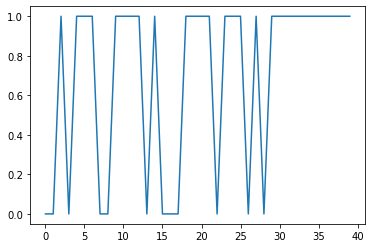

In [10]:
plt.plot(accuracy[0])

In [27]:
nbacks

[5]

## This Sim Analysis

In [7]:
filamentVal = '2'
reinforcement='no'
if reinforcement == 'w':
    loadName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(nbacks[0])+'_filament'+filamentVal+'_DataSimOnly'
else:
    loadName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(nbacks[0])+'_filament'+filamentVal+'_noReinforcement_DataSimOnly'

with open(dataLoc+'Sim Results/'+loadName+'.pkl', 'rb') as f:
    sims=pickle.load(f)[0]

In [9]:
filamentVal = '2'
reinforcement='no'
if reinforcement == 'w':
    loadName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(nbacks[0])+'_filament'+filamentVal+'_DataNoSim'
else:
    loadName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(nbacks[0])+'_filament'+filamentVal+'_noReinforcement_DataNoSim'

with open(dataLoc+'Sim Results/'+loadName+'.pkl', 'rb') as f:
    dataNoSim=pickle.load(f)[0]

In [183]:
dataNoSim.keys()

dict_keys(['current', 'threshold', 'accuracy', 'targets', 'training order', 'training labels', 'testing labels', 'all labels', 'num test samples', 'Parameters'])

In [10]:
acc=[]
for l in dataNoSim['accuracy']:
    l = np.array(l[:40])
    acc.append(l) 

(-0.05, 1.05)

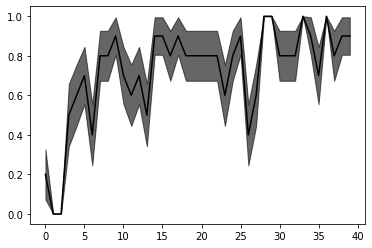

In [11]:
plt.figure()
ax=plt.gca()
mean=np.mean(np.array(acc),axis=0)
se=np.std(np.array(acc),axis=0)/np.sqrt(len(acc))
x=range(len(mean))
ax.plot(x,mean,c='k')
ax.fill_between(x,mean+se,mean-se,color='k',alpha=0.6)
ax.set_ylim([-0.05,1.05])
# plt.savefig(saveFig+'698nw_2582nj_working_memory_nback_'+reinforcement+'Reinforcement_accuracy_b'+filamentVal+'.pdf',format='pdf',dpi=300)

In [170]:
curr=np.zeros((len(dataNoSim['current']),len(dataNoSim['current'][0][0])))
i=0
for l in dataNoSim['current']:
    a = np.array(l[0][0])
    curr[i]=np.array(a[0])
    i+=1

In [173]:
curr

array([[9.02617691e-09],
       [1.48952689e-08],
       [9.02617691e-09],
       [1.48952689e-08],
       [9.02617691e-09],
       [1.48952689e-08],
       [9.02617691e-09],
       [9.02617691e-09],
       [9.02617691e-09],
       [9.02617691e-09]])

In [174]:
meanThresh1=np.mean(np.array(curr),axis=0)[:,0]
meanThresh2=np.mean(np.array(curr),axis=0)[:,1]

seThresh1=np.std(np.array(curr),axis=0)[:,0]/np.sqrt(120)
seThresh2=np.std(np.array(curr),axis=0)[:,1]/np.sqrt(120)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [145]:
thresh=[]
for l in dataNoSim['threshold']:
    l = np.array(l[:40])
    thresh.append(l) 

In [146]:
meanThresh1=np.mean(np.array(thresh),axis=0)[:,0]
meanThresh2=np.mean(np.array(thresh),axis=0)[:,1]

seThresh1=np.std(np.array(thresh),axis=0)[:,0]/np.sqrt(40)
seThresh2=np.std(np.array(thresh),axis=0)[:,1]/np.sqrt(40)

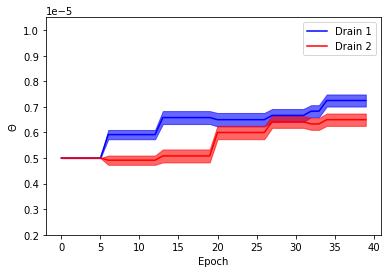

In [147]:
plt.figure()
ax=plt.gca()
ax.plot(meanThresh1,label='Drain 1',c='b')
ax.fill_between(x,meanThresh1-seThresh1,meanThresh1+seThresh1,color='b',alpha=0.6)
ax.plot(meanThresh2,label='Drain 2',c='r')
ax.fill_between(x,meanThresh2-seThresh2,meanThresh2+seThresh2,color='r',alpha=0.6)
ax.set_xlabel('Epoch')
ax.set_ylabel('$\Theta$')
ax.set_ylim([0.2e-5,1.05e-5])
plt.legend()
plt.savefig(saveFig+'698nw_2582nj_working_memory_nback_'+reinforcement+'Reinforcement_Theta_Threshold_b'+filamentVal+'.pdf',format='pdf',dpi=300)

In [148]:
p1acc=np.array(accuracy[:40])[testingLabels==0]
p2acc=np.array(accuracy[:40])[testingLabels==1]

/suphys/aloe8475/anaconda3/envs/phd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


(0.0, 1.0)

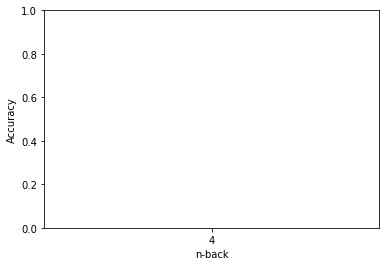

In [149]:
plt.plot(np.mean(p1acc),'x')
plt.plot(np.mean(p2acc),'+')
plt.ylabel('Accuracy')
plt.xticks([0])
ax=plt.gca()
ax.set_xticklabels([4])
ax.set_xlabel('n-back')
ax.set_ylim([0,1])

In [176]:
#REACTION TIME:
# jV=[]
# jF=[]
# jC=[]
# activeSources=[]
elecItrain=[];elecItest=[];inputSignal=[]
drain1=[];drain2=[]
t=0
nback=nbacks[0]
for i in range(len(sims['sim'])):
#     jV.append(sim[i].junctionVoltage)   
#     jF.append(sim[i].filamentState) #Junction Filament Negative
#     jC.append(sim[i].junctionConductance)
#     activeSources.append(sim[i].sources)
    if sims['sim'][i].electrodeCurrent.shape[1] == 10:
        elecItrain.append(sims['sim'][i].electrodeCurrent[:,0])
    else: #only test:
#         if len(elecItest[i]) < 600:
        elecItest.append(sims['sim'][i].electrodeCurrent[:,:2])
        drain1.append(elecItest[t][:,0])
        drain2.append(elecItest[t][:,1])
        t+=1
        
# rampV=np.linspace(0,onAmpTest,TlenTest)

In [177]:
drain1=np.hstack(np.array(drain1))
drain2=np.hstack(np.array(drain2))

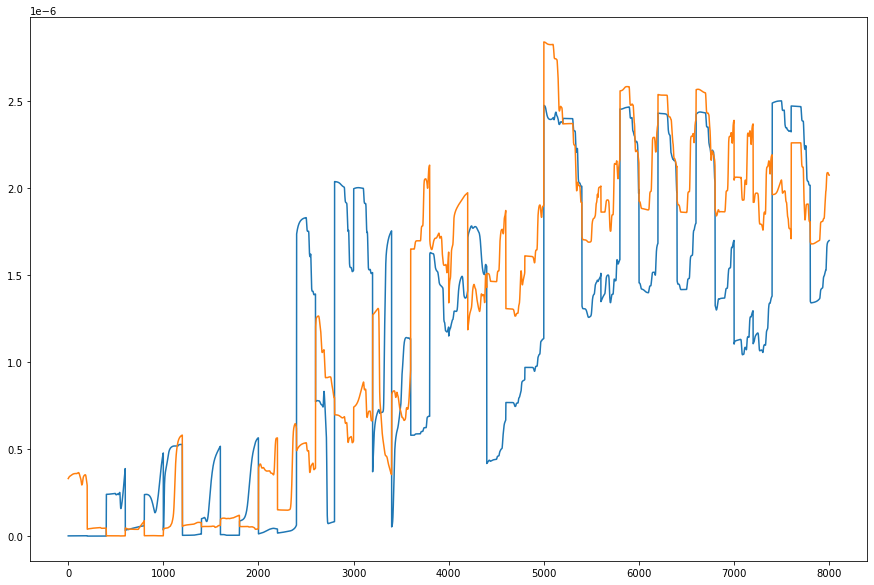

In [178]:
plt.figure(figsize=(15,10))
plt.plot(drain1)
plt.plot(drain2)
ax=plt.gca()


NameError: name 'targetsNew' is not defined

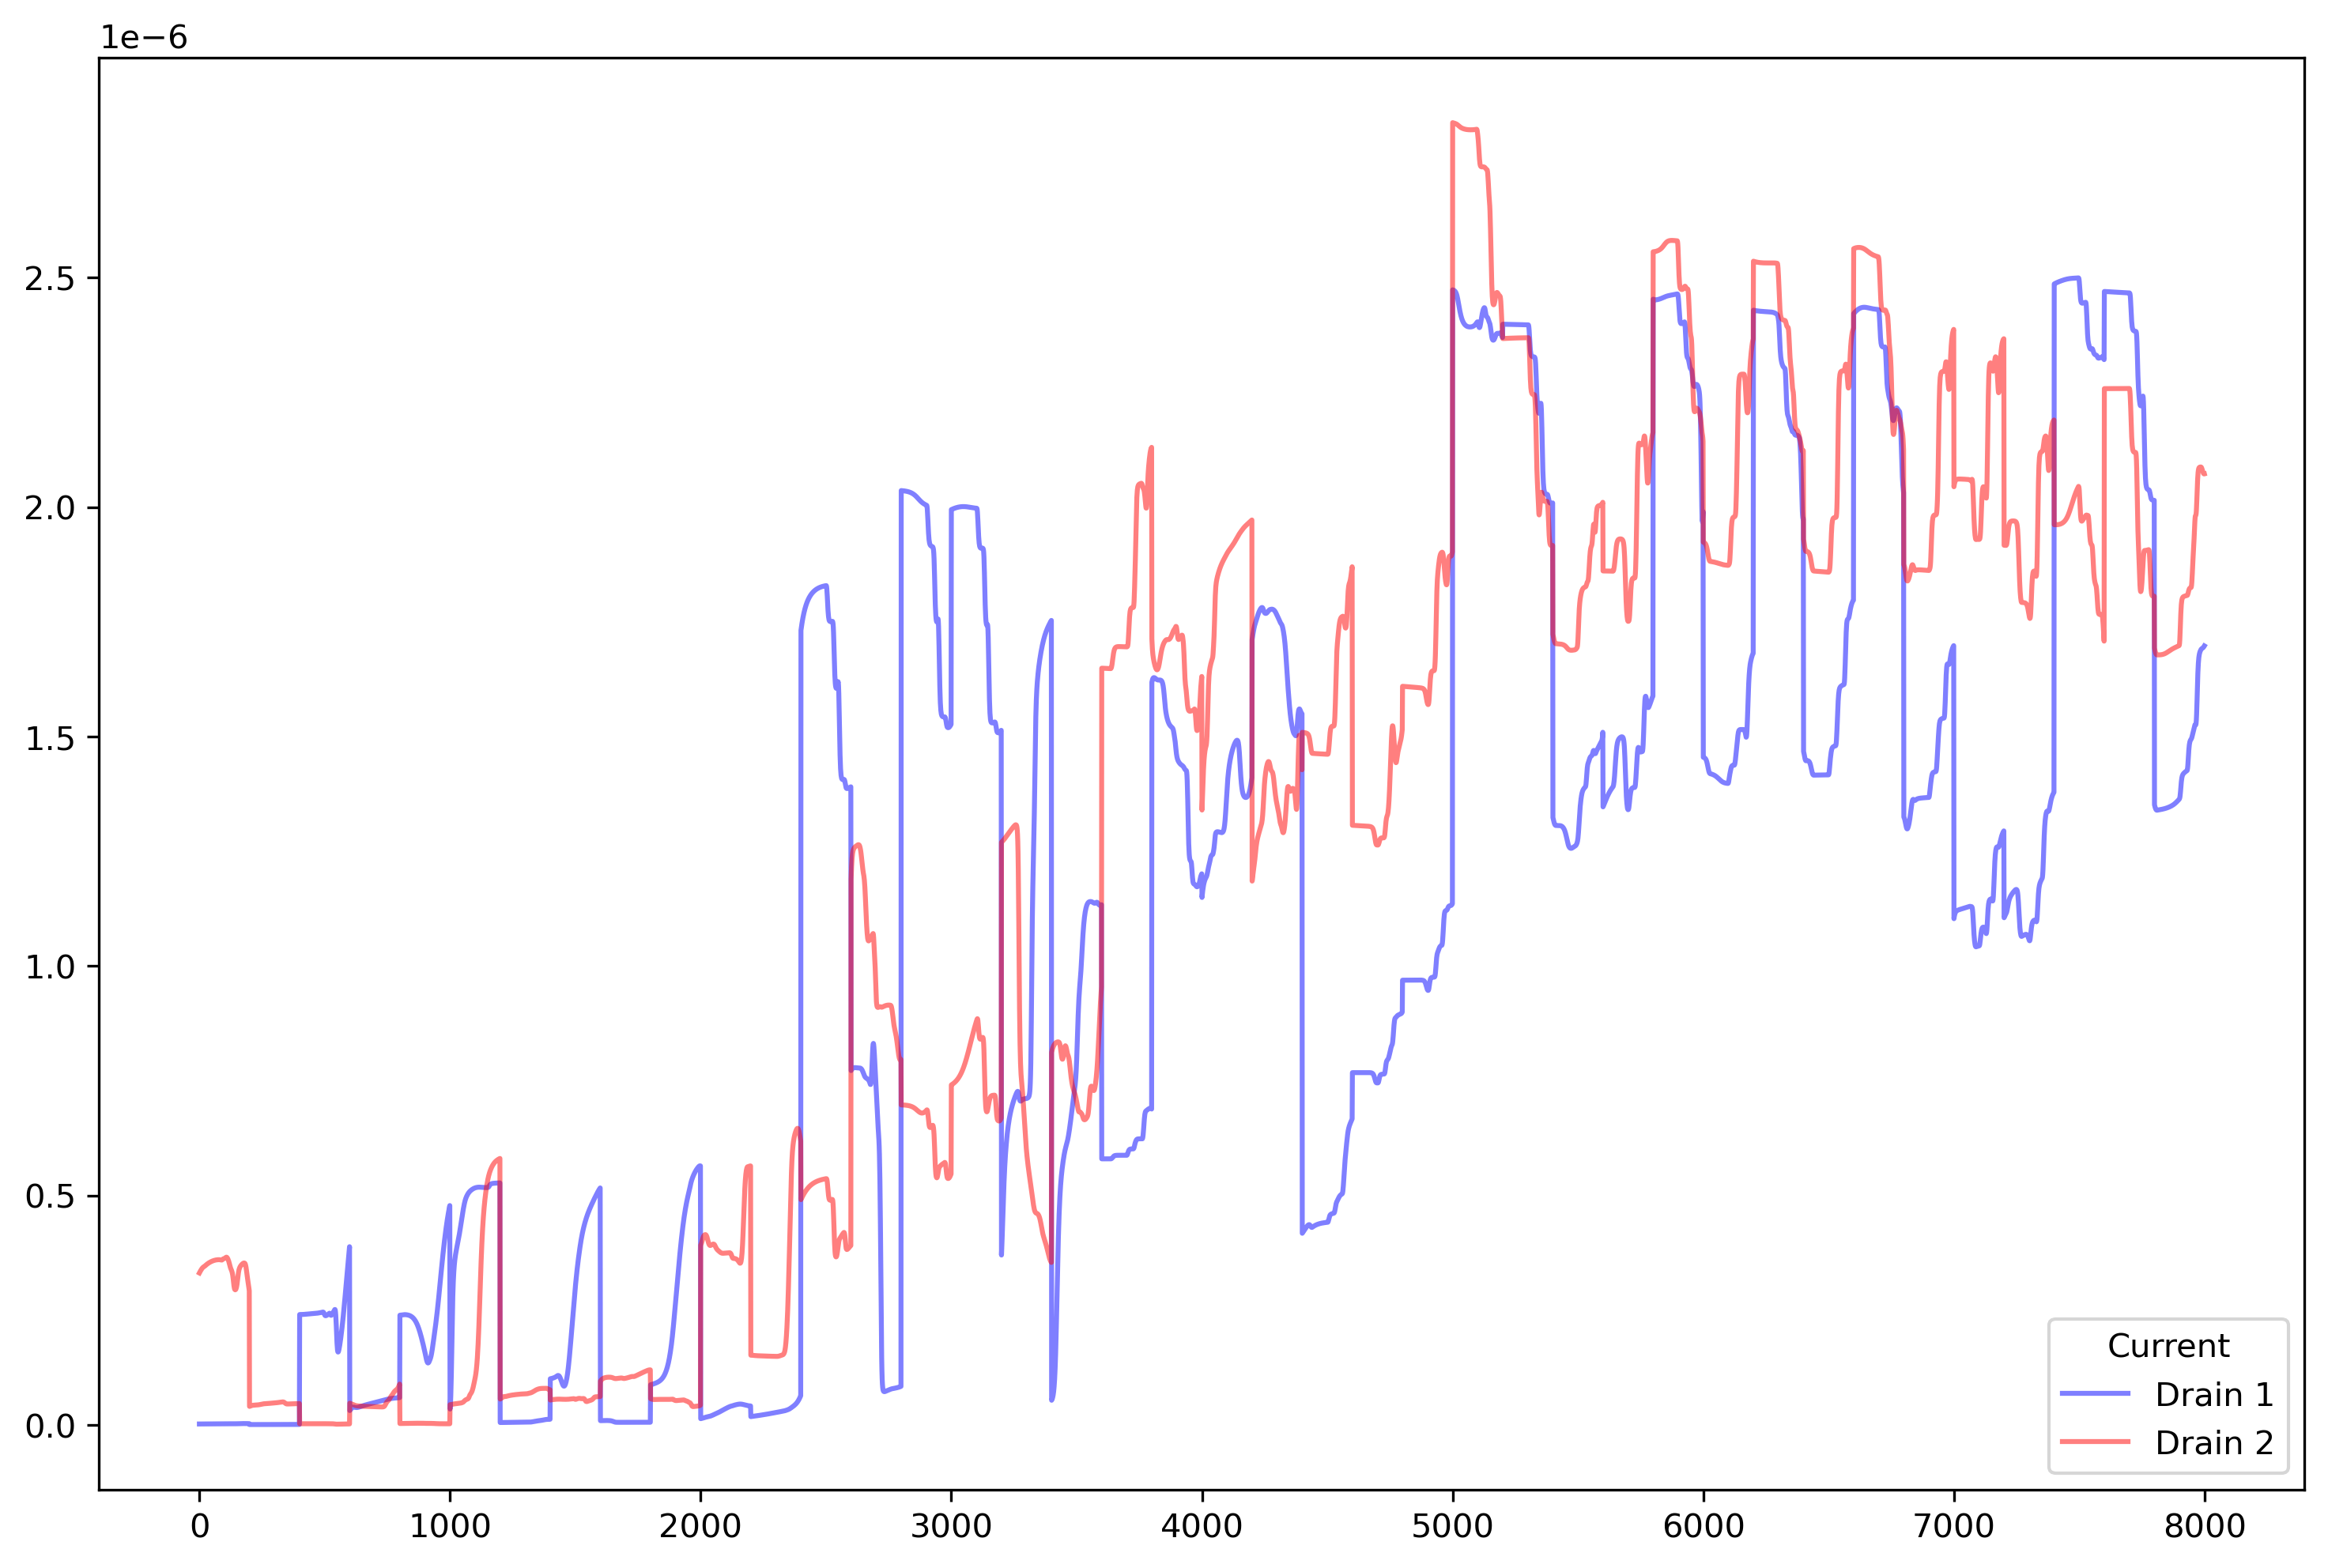

In [179]:
#Current Strength vs Accuracy:
plt.rcParams['pdf.fonttype'] = 42


fig,ax = plt.subplots(1,1, figsize=(12, 8), dpi=300)
p1=ax.plot(drain1,'b',alpha=0.5)
p2=ax.plot((drain2),'r',alpha=0.5)
plt.legend([p1[0],p2[0]],['Drain 1','Drain 2'],loc='lower right',title='Current')


if nback == 1:
    xlimmax=830
    vlinesStep=40
    vlinesStart=30
    dotpos=2

if nback == 2:
#     xlimmax=1230
    vlinesStep=600
    vlinesStart=500
    dotpos=3
elif nback == 3:
    xlimmax=1630
    vlinesStep=80
    vlinesStart=70
    dotpos=4
    
colrs=[]
for val in targetsNew:
    if val < 1:
        colrs.append('C1')
    else:
        colrs.append('C2')    

testColors=[]
for i in colrs:
    if i == 'C1':
        testColors.append('b')
    else:
        testColors.append('r')
        
ax.set_xlabel('Time')
ax.set_ylabel('Current')
# ax.set_xlim([-600,24400])

ax.vlines(range(vlinesStart,len(drain1),vlinesStep),np.min(drain2),np.max(drain2),linestyle='dashed',color=testColors,alpha=0.5)

ax2=ax.twinx().twiny()
ax2.scatter(list(range(0,len(targetsNew),1)),accuracy,c=testColors)
ax2.set_ylim([-0.05,1.05])



ax2.set_xlabel('Sample Num')
ax2.set_ylabel('Accuracy')

# fig.savefig(saveFig+'698w_2582j_current_time_accuracy_nback2_2x2_b2.pdf',format='pdf',dpi=300)


In [78]:
rt1=[];rt2=[]
for test in elecItest:
    threshReachedBool1=np.array(np.where(test[:,0]>=0.6e-6))
    threshReachedBool2=np.array(np.where(test[:,1]>=0.6e-6))
    if threshReachedBool1.size > 0 :
        rt1.append(np.min(threshReachedBool1))
    else:
        rt1.append(np.nan)
        
    if threshReachedBool2.size > 0 :
        rt2.append(np.min(threshReachedBool2))
    else:
        rt2.append(np.nan)  
    
rt1=np.array(rt1)
rt2=np.array(rt2)
rt1=rt1[~np.isnan(rt1)]
rt2=rt2[~np.isnan(rt2)]

In [79]:
rt1

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       133., 107.,   0.,   0., 178.,   0.,   0., 153., 126.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])

In [80]:
rt2

array([ 48.,  14.,  30.,  91., 148.,   0., 145.,   0., 111.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fda5a8a83d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fda5a8a8670>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fda5ae15b50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fda5b04cd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fda5ab80760>],
 'means': []}

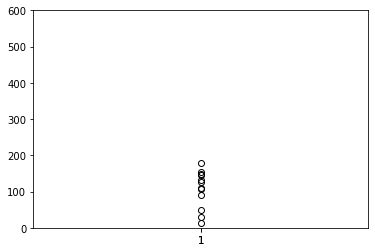

In [81]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha=0.7)       
        
    return bp
fig,ax=plt.subplots()
ax.set_ylim([0,600])
box_plot(rt1,'b','b')
box_plot(rt2,'r','r')

# plt.boxplot([rt2],patch_artist=True,boxprops=dict(facecolor='w', color='r'))


In [82]:
# savemat(dataLoc+'nback'+str(nbacks[0])+'_accuracy_plus_cross_b0p5.mat',{'Accuracy':accuracy,'ReactionTime':[rt1,rt2]})

## LOAD ALL SIMS:

In [129]:
nbacks=[2,3,4,5,6]
i=0
data=[]
accuracies=[]
filamentVal='0p5'
reinforcement='no'

for n in tqdm(nbacks):
#     saveName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn0.3_Vtst0.1_beta0p5_T200_plus_cross_nback'+str(n)+'_filament0p5'
    saveName='data_'+str(nwSize)+'nw_'+str(nwJunctions)+'nj_3x3_wThresh_Vtrn'+str(onAmp)+'_Vtst'+str(onAmpTest)+'_T200_plus_cross_nback'+str(n)+'_filament'+filamentVal+'_'+reinforcement+'Reinforcement_DataNoSim'
    with open(dataLoc+'/Sim Results/'+saveName+'.pkl', 'rb') as f:
        data.append(pickle.load(f))
    accuracies.append(data[i][0]['accuracy'])
    i+=1

  0%|          | 0/5 [00:00<?, ?it/s]

#### ACCURACY

In [130]:
acc_arr=np.array([item for sublist in accuracies for subsublist in sublist for item in subsublist[:40]]).reshape(5,10,40)

In [131]:
np.mean(acc_arr,axis=2)[0]

array([0.575, 0.625, 0.9  , 0.55 , 0.925, 0.925, 0.725, 0.625, 0.925,
       0.825])

In [132]:
#SEM across epochs:

if reinforcement == 'w':
    meanAcc_epochs_Reinf=[];stdAcc_epochs_Reinf=[]
    for i in range(len(acc_arr)):
        meanAcc_epochs_Reinf.append(np.mean(np.mean(acc_arr,axis=1)[i]))
        stdAcc_epochs_Reinf.append(np.std(np.mean(acc_arr,axis=1)[i]))
    seAcc_epochs_Reinf=np.array(stdAcc)/np.sqrt(40)
else:
    meanAcc_epochs_noReinf=[];stdAcc_epochs_noReinf=[]
    for i in range(len(acc_arr)):
        meanAcc_epochs_noReinf.append(np.mean(np.mean(acc_arr,axis=1)[i]))
        stdAcc_epochs_noReinf.append(np.std(np.mean(acc_arr,axis=1)[i]))
    seAcc_epochs_noReinf=np.array(stdAcc)/np.sqrt(40)

In [139]:
np.std(np.mean(acc_arr,axis=1)[0])

0.1854723699099141

In [138]:
np.std(np.mean(acc_arr,axis=2)[0])

0.14882876066137218

In [108]:
#SEM across experiments
i=0
if reinforcement == 'w':
    meanAcc_Reinf=[[]*10 for i in range(5)];stdAcc=[[]*10 for i in range(5)]
    for a in accuracies: #for each nback
        a=np.array([np.array(ai[:40]) for ai in a])
        meanAcc_Reinf[i].append(np.mean(a))
        stdAcc[i].append(np.std(a))
        i+=1
    seAcc_Reinf=np.array(stdAcc)/np.sqrt(40)
else:
    meanAcc_noReinf=[[]*10 for i in range(5)];stdAcc=[[]*10 for i in range(5)]
    for a in accuracies: #for each nback
        a=np.array([np.array(ai[:40]) for ai in a])
        meanAcc_noReinf[i].append(np.mean(a))
        stdAcc[i].append(np.std(a))
        i+=1
    seAcc_noReinf=np.array(stdAcc)/np.sqrt(40)

In [109]:
import pandas as pd
#EXPERIMENTAL RESULTS:
#LOAD EXPERIMENTAL DATA:
loadLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/Adrian Results/Task 2/'
fileName='non_reinforce_xp_pl__11_40_24_PD.csv'
fileName2='reinforce_xp_pl__11_39_57_PD.csv'

dataExp=pd.read_csv(loadLoc+fileName)
dataExp2=pd.read_csv(loadLoc+fileName2)

In [110]:
dataExp2

,hamming_dist,globalAccuracy,mix_accuracy,threshold_type,backdegree,commit?,pathway_intersection
0,0.888889,0.71,0.453762,2,2.0,1,13
1,0.888889,0.73,0.443959,2,3.0,1,13
2,0.888889,0.95,0.217945,2,4.0,1,13
3,0.888889,0.97,0.170587,2,5.0,1,13
4,0.888889,1.00,0.000000,2,6.0,1,13


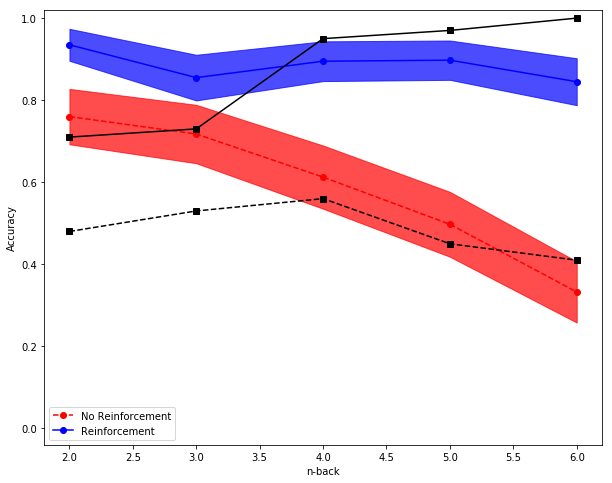

In [111]:
#MEAN AND SEM ACROSS EXPERIMENTS

plt.rcParams['pdf.fonttype'] = 42

plt.figure(figsize=(10,8))
nbacks=[2,3,4,5,6]
# for i in range(len(meanAcc)):
yerr1=np.array(seAcc_noReinf).reshape(-1)
y1 = np.array(meanAcc_noReinf).reshape(-1)
yerr2=np.array(seAcc_Reinf).reshape(-1)
y2 = np.array(meanAcc_Reinf).reshape(-1)

plt.plot(nbacks,y1,'--o',c='r')
plt.fill_between(nbacks,y1+yerr1,y1-yerr1,alpha=0.7,color='r')
plt.plot(nbacks,y2,'-o',c='b')
plt.fill_between(nbacks,y2+yerr2,y2-yerr2,alpha=0.7,color='b')

plt.plot(nbacks,dataExp['globalAccuracy'],'--s',c='k')
plt.plot(nbacks,dataExp2['globalAccuracy'],'-s',c='k')

plt.xlabel('n-back')
plt.ylabel('Accuracy')
plt.ylim([-0.04,1.02])


plt.legend(['No Reinforcement','Reinforcement'])

plt.savefig(saveFig+'698nw_2582nj_plus_cross_nback23456_Sim_Experiment_b'+filamentVal+'.pdf',format='pdf',dpi=300)

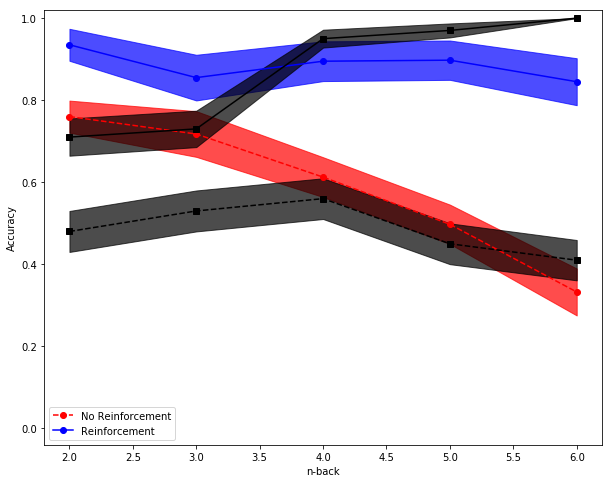

In [140]:
#MEAN AND SEM ACROSS EPOCHS

plt.rcParams['pdf.fonttype'] = 42

plt.figure(figsize=(10,8))
nbacks=[2,3,4,5,6]
# for i in range(len(meanAcc)):
yerr1=np.array(seAcc_epochs_noReinf).reshape(-1)
y1 = np.array(meanAcc_epochs_noReinf).reshape(-1)
yerr2=np.array(seAcc_epochs_Reinf).reshape(-1)
y2 = np.array(meanAcc_epochs_Reinf).reshape(-1)

plt.plot(nbacks,y1,'--o',c='r')
plt.fill_between(nbacks,y1+yerr1,y1-yerr1,alpha=0.7,color='r')
plt.plot(nbacks,y2,'-o',c='b')
plt.fill_between(nbacks,y2+yerr2,y2-yerr2,alpha=0.7,color='b')


seExpReinf=dataExp2['mix_accuracy'].values/np.sqrt(100)
seExpNoReinf=dataExp['mix_accuracy'].values/np.sqrt(100)

plt.plot(nbacks,dataExp['globalAccuracy'],'--s',c='k')
plt.fill_between(nbacks,dataExp['globalAccuracy']+seExpNoReinf,dataExp['globalAccuracy']-seExpNoReinf,alpha=0.7,color='k')

plt.plot(nbacks,dataExp2['globalAccuracy'],'-s',c='k')
plt.fill_between(nbacks,dataExp2['globalAccuracy']+seExpReinf,dataExp2['globalAccuracy']-seExpReinf,alpha=0.7,color='k')

plt.xlabel('n-back')
plt.ylabel('Accuracy')
plt.ylim([-0.04,1.02])


plt.legend(['No Reinforcement','Reinforcement'])

plt.savefig(saveFig+'698nw_2582nj_plus_cross_nback23456_Sim_SEMepochs_Experiment_b'+filamentVal+'.pdf',format='pdf',dpi=300)

In [102]:
#Split accuracies:

nbacks=[2,3,4,5,6]#,7,8]
outputs=[]
for n in tqdm(nbacks):
    #Cross and Plus:
    saveName='data_698nw_2582nj_3x3_wThresh_Vtrn0.3_Vtst0.1_beta0p5_T200_plus_cross_nback'+str(n)+'_filament5'

    #simple:
#     saveName='data_698nw_2582nj_3x3_wThresh_Vtrn0.3_Vtst0.1_beta0p5_T200_oneDrainTrain_nback'+str(n)+'_filament0p5'
    with open(dataLoc+saveName+'.pkl', 'rb') as f:
        outputs.append(pickle.load(f))
        
# outputs[0]=[outputs[0]] #fix annoying data structure for nback 2 of the simple case

  0%|          | 0/5 [00:00<?, ?it/s]

In [103]:
p1Acc=[];p2Acc=[]
p1avg=[];p2avg=[];p1std=[];p2std=[]
for i in range(len(outputs)):
    p1Acc.append(np.array(outputs[i][0]['accuracy'])[:40][outputs[i][0]['testing labels']==0])
    p2Acc.append(np.array(outputs[i][0]['accuracy'])[:40][outputs[i][0]['testing labels']==1])
    p1avg.append(np.mean(p1Acc[i]))
    p2avg.append(np.mean(p2Acc[i]))
    p1std.append(np.std(p1Acc[i]))
    p2std.append(np.std(p2Acc[i]))

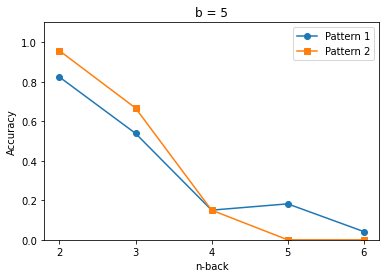

In [104]:
plt.plot(p1avg,'-o',label='Pattern 1')
plt.plot(p2avg,'-s',label='Pattern 2')
ax=plt.gca()
ax.set_title('b = 5')

ax.set_xticklabels([2,3,4,5,6])#,7,8,9])
ax.set_xticks([0,1,2,3,4])#,7,8,9])

ax.set_xlabel('n-back')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1.1])
plt.legend()

plt.savefig(saveFig+'698nw_2582nj_plus_cross_Adrian_nback_Accuracy_b5.pdf',format='pdf',dpi=300)